In [2]:
# dependencies
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import pandas as pd
import qrpm_funcs as qf
from mpl_toolkits import mplot3d
from datetime import datetime
from itertools import chain
from matplotlib import cm
import scipy.stats as scistat
import scipy.optimize as sciopt
import scipy.interpolate as scint
from datetime import date
from mpl_toolkits import mplot3d
from datetime import datetime, timedelta
from itertools import chain
import warnings
warnings.filterwarnings("ignore")
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve

In [3]:
'''
Simulating the path to generate paths for Quanto payoffs.
'''
# paths = 1000
# steps = 1000
# z1 = np.random.standard_normal(size = (paths, steps))
# z2 = np.random.standard_normal(size = (paths, steps))

def calc_quanto_pricer(r_local, S0, strike, corr, vol_idx, vol_fx, paths, steps, z1):
    
    price_paths = np.zeros( ( paths, (steps)), np.float64)   #  allocate path array
    for i in range(paths):
        price_paths[i,0] = S0
        
    dt = 0.001    
    
    for k in range(steps - 1):  # take a time step for all n paths at once
        
        price_paths[:,k+1] = price_paths[:,k] + (r_local - corr * vol_idx * vol_fx)*price_paths[:,k]*dt + z1[:,k]*price_paths[:,k]*vol_idx*np.sqrt(dt)
    
    price_paths = (price_paths[:, steps - 1]/S0 - strike)
    #price_paths = np.average(price_paths)
    return (price_paths)


In [4]:
'''
Simulating the paths for Hull-White model

Generating rates upto T + delta, and finding the payoff at time T.  

'''

def calc_caplet_pricer(theta, L0, strike, alpha, sigma, paths, steps, z1, z2, rho, extra_steps):
    
    price_paths = np.zeros( (paths, (steps)), np.float64)
    w = rho * z1 + np.sqrt(1 - rho*rho) * z2
    
    for i in range(paths):
        price_paths[i,0] = L0
    
    dt = 0.001
    
    for k in range(steps - 1):
        
        price_paths[:,k+1] = price_paths[:,k] + (theta - alpha * price_paths[:,k])*dt + w[:,k]*sigma*np.sqrt(dt)

    extra_paths = np.zeros((paths, (extra_steps)), np.float64)
    
    for i in range(paths):
        extra_paths[i,0] = price_paths[i, steps - 1]
        
    for k in range(extra_steps - 1):
        extra_paths[:,k+1] = extra_paths[:,k] + (theta - alpha * extra_paths[:,k])*dt + np.random.standard_normal(size = paths)*sigma*np.sqrt(dt)
    
    disc_extra_paths = extra_paths[:, extra_steps - 1] * np.exp(-0.049*0.25)
    disc_price_paths = (strike - disc_extra_paths/L0)
    #price_paths = np.average(price_paths)
    print(disc_price_paths)
    return disc_price_paths

#paths_cap = calc_caplet_pricer(0.09, 0.05, 1.5, 0.06, 0.04, paths, steps, z1, z2, 0.6, 100)

In [5]:
'''
Converting the black-scholes volatility to Hull-White volatility
'''
def convert_volatility(bs_sigma, alpha, delta_T, T):
        
    sigma = bs_sigma * (np.sqrt(T)*pow(alpha, 1.5)*np.sqrt(2))/((1 - np.exp(-alpha * delta_T))*np.sqrt(1 - np.exp(-2*alpha*T)))

    return sigma

In [6]:
libor_curve = [0.0471, 0.049, 0.052, 0.0525, 0.0539, 0.0540, 0.0551, 0.0562, 0.0578, 0.0631]
yield_curve = [0.0377, 0.0434, 0.0467, 0.0468, 0.0470, 0.0406, 0.0375, 0.0361, 0.0357, 0.0365]
maturities = [1/12, 1/4, 1/2, 1, 2, 3, 5, 7, 10, 30]
jpy_yield_curve = [0.0, 0.0, 0.0, 0.0012, 0.0024, 0.0112, 0.0146]
jpy_maturities = [0.5, 1, 2, 5, 10, 20, 30]

'''
Calibrating Theta in Hull White
'''

def get_theta(alpha, sigma, t):
    rates = scint.CubicSpline(maturities, libor_curve)
    plt.xlabel("T")
    plt.ylabel("UST Yield Curve")
    plt.title("United States Treasury Curve Plot")
    X = np.linspace(0, 30, num=100, endpoint=True)
    Y = rates(X)
    plt.plot(X, Y)
    drates = scint.CubicSpline.derivative(rates)
    g = ((sigma**2)*(1 - np.exp(-2*alpha*t)))/(2*alpha)
    gd = ((sigma**2)*np.exp(-2*alpha*t))
    
    return rates(t) + gd + alpha*(rates(t) + g)

0.08829897776443174

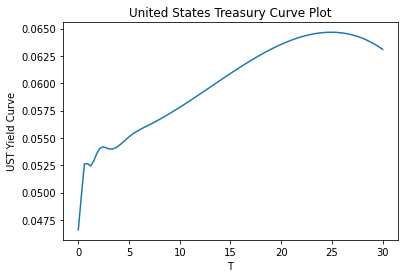

In [7]:
### Generate sigmap

get_theta(0.03, 0.2, 30)

In [8]:
lastday=qf.LastYearEnd()
one_year_start_date = '2020-12-12'
start_date = '2006-12-31'


'''

Get N225 historical data
'''

def get_nikkei_historical(start_date):
    
    lastday=qf.LastYearEnd()
    n225 = yf.Ticker('^N225').history(period='1d', start = start_date, end = lastday)
    n225_data = n225["Close"]
    n225_data = np.array(n225_data)

    previous = n225_data[0]
    n225_log_returns = []
    
    for i in range(1, len(n225_data)):
        n225_log_returns.append(np.log(n225_data[i]/previous))
        previous = n225_data[i]
        
    return n225_data

'''
Get FX historical data
'''

def get_fx_historical():

    lastday=qf.LastYearEnd()
    #Swiss franc, pound sterling, Japanese Yen
    seriesnames=['DEXJPUS']
    cdates,ratematrix=qf.GetFREDMatrix(seriesnames,startdate = '2007-05-12', enddate=lastday)
    multipliers=[1]

    lgdates,difflgs=qf.levels_to_log_returns(cdates,ratematrix,multipliers)

    #Mean vector and covariance matrix are inputs to efficient frontier calculations
    d=np.array(difflgs)
    #*************************End code from Chapter 4
    #vals = [i for i in difflgs]
    
    return ratematrix

'''
Generate Equity FX correlations

'''

def get_equity_fx_correlation():
    
    fx_ret = np.array(get_fx_historical())
    fx_historical = fx_ret.reshape((len(fx_ret),))
    fx_historical = fx_historical[~np.isnan(fx_historical)]
    
    nikkei_historical = np.array(get_nikkei_historical(start_date))
    
    fx_historical = fx_historical[:nikkei_historical.shape[0]]
    
    # expanding the 0th dimension
    nikkei_historical = np.expand_dims(nikkei_historical,axis=0)
    fx_historical = np.expand_dims(fx_historical,axis=0)
    
    return np.corrcoef(fx_historical, nikkei_historical)[0][1]


'''SPX Historicals for benchmarking'''

def get_spx_historical():
    
    #spx = yf.Ticker('GSPC').history(period='1d', start='2016-12-31', end='2022-12-12')
    spx = yf.download('^GSPC', period='1d', start='2016-12-31', end=lastday)
    return np.array(spx['Adj Close'])

'''
LIBOR historicals
'''

def get_LIBOR_3m():
    
    libor = pd.read_csv('LIBOR3m.csv')
    libor = np.array(libor['Close'])
    for i in range(len(libor)):
        libor[i] = libor[i].replace('%', '')
        libor[i] = float(libor[i])
    libor = libor.astype(float)
    libor_log_returns = []
    previous = libor[0]
    
    for i in range(1, len(libor)):
        libor_log_returns.append(np.log(libor[i]/previous))
        previous = libor[i]
        
    return libor_log_returns

'''
Generate LIBOR N225 correlations
'''

def get_LIBOR_N225():
    
    L3m_ret = get_LIBOR_3m()
    #fx_historical = fx_ret.reshape((len(fx_ret),))
    nikkei_historical = np.array(get_nikkei_historical(one_year_start_date))
    
    return np.corrcoef(L3m_ret, nikkei_historical)[0][1]

In [9]:
def getSVICurve (parameters, moneyness):
    a = parameters[0]
    b = parameters[1]
    rho = parameters[2]
    m = parameters[3]
    sigma = parameters[4]
    return [a+b*(rho*(k-m)+np.sqrt((k-m)**2 + sigma**2)) for k in moneyness]

## SVI value
def sviCurve(a, b, rho, m, tau, k):
    y = a + b * (rho * (k - m) + np.sqrt((k - m) ** 2 + tau ** 2))
    if y>=0:
        return np.sqrt(y) # it returns the square root of the variance
    else:
        return 0
      
## first derivate of SVI formula
def sviCurveDerivate(b, rho, m, tau, k):
    return b * (rho + (k - m) / np.sqrt((k - m) ** 2 + tau ** 2))

## second derivate of SVI formula
def sviCurve2ndDerivate(b, m, tau, k):
    return b * tau * tau / np.power((k - m) ** 2 + tau ** 2, 1.5)

## g-function used to check butterfly arbitrage
def gFunction(a, b, rho, m, tau, S, time2Maturity, vecStrike):
    moneyness = [np.log(k / S) for k in vecStrike]
    g = []
    for k in moneyness:
        w = (sviCurve(a, b, rho, m, tau, k)**2) * time2Maturity
        wd = sviCurveDerivate(b, rho, m, tau, k) * time2Maturity
        wdd = sviCurve2ndDerivate(b, m, tau, k) * time2Maturity
        if w!=0:
            g.append((1 - k * wd / (2 * w)) ** 2 - (wd * wd / 4) * (1 / w + 0.25) + wdd / 2)
        else:
            g.append(-1)
    return g


# volCoef-> array storing SVI parameters
# vecStrikePrice-> array containing strike prices
# S-> spot price
def butterflyArbitrage(volCoef, S, time2Maturity, vecStrikePrice):    
    a = volCoef[0]
    b = volCoef[1]
    rho = volCoef[2]
    m = volCoef[3]
    tau = volCoef[4]
    g = gFunction(a, b, rho, m, tau, S, time2Maturity, vecStrikePrice)
    return np.exp([0.0 if gi>=0 else 1 for gi in g])

#### check if calculated value is within bid-ask spread

def envelopeCondition(pAdjusted, bid, ask):
    val = np.clip([0.0 if (pi>=bi and pi<=ai) else 2*np.fabs(pi-(ai+bi)/2)/(ai-bi) for pi, bi, ai in zip(pAdjusted, bid, ask)],
                          a_min=None,
                          a_max=10000)
    val = [ float(i) for i in val]
    return np.exp(val)

#### obtain price of an option by Black-Scholes model

def optionPrice(optionType, S, r, volCoef, time2Maturity, vecStrikePrice):
    moneyness = [np.log(k / S) for k in vecStrikePrice]
    optionPriceList=[]
    for k, mn in zip(vecStrikePrice, moneyness):
        vol = sviCurve(volCoef[0], volCoef[1], volCoef[2], volCoef[3], volCoef[4], mn)
        if vol!=0:
            if optionType == "Call":
                optionPriceList.append(BS.Call.Price(S, k, r, vol,time2Maturity))
            elif optionType == "Put":
                optionPriceList.append(Put.Price(S, k, r, vol,time2Maturity))
        else:
            optionPriceList.append(S)
    return optionPriceList

#### objective function

# volMarket, bid, ask-> arrays with market data of implied volatility
# optionType-> string 'Call' or 'Put'
def globalOptimization(X, volMarket, bid, ask, optionType, S0, time2Maturity, vecStrikePrice, r):
    moneyness = [np.log(k / S0) for k in vecStrikePrice]
    volAdjusted = getSVICurve(X, moneyness)    
    
    pAdjusted = optionPrice(optionType=optionType,
                            S=S0,
                            r=r,
                            volCoef=X,
                            time2Maturity=time2Maturity,
                            vecStrikePrice=vecStrikePrice)
    ## penalizations
    #print(pAdjusted)
    consButterfly = butterflyArbitrage(X, S0, time2Maturity, vecStrikePrice)
    consEnvelope = envelopeCondition(pAdjusted, bid, ask)

    OF = np.array([(volAdj/volMar - 1)*bi*ei for volAdj,volMar, bi,ei in zip(volAdjusted, volMarket, consButterfly, consEnvelope)])
    return np.sum(OF**2)

parameters_call = [[0.1998, 0.1273, -5.552, 0.0644, 0.002], [0.0872, 1.3634, 0.2365, 0.0302, 0.002], 
                  [0.0537, 2.18, 0.3435, 0.0399, 0.0299], [0.0463, 2.6030, 0.2067, 0.0299, 0.002],
                  [0.2552, -0.2282, 4.0272, 0.01, 0.03], [0.1083, 48.6448, 0.9807, 0.16, 0.01] ]

## follow-up function
def callbackFunction(X, convergence):
    xProgress.append(X) # global variable containing progress of the optimization process

def d1(S, K, r, sigma, T):
    return (np.log(S/K) + (r+sigma*sigma/2)*T)/(sigma*np.sqrt(T))

def d2(S, K, r, sigma, T):
    return d1(S, K, r, sigma, T) - sigma*np.sqrt(T)
'''
Input parameters:
S -> asset price
K -> strike price
r -> interest rate
sigma -> volatility
T -> time to maturity
'''
class Put:
    def Price(S, K, r, sigma, T):
        return K*np.exp(-r*T)*scistat.norm.cdf(-1*d2(S, K, r, sigma, T)) - S*scistat.norm.cdf(-1*d1(S, K, r, sigma, T))

    def Delta(S, K, r, sigma, T):
        return scistat.norm.cdf(d1(S, K, r, sigma, T)) - 1

    def Gamma(S, K, r, sigma, T):
        return scistat.norm.pdf(d1(S, K, r, sigma, T))/(S*sigma*np.sqrt(T))

    def Vega(S, K, r, sigma, T):
        return S*scistat.norm.pdf(d1(S, K, r, sigma, T))*np.sqrt(T)

    def Theta(S, K, r, sigma, T):
        aux1 = -S*scistat.norm.pdf(d1(S, K, r, sigma, T))*sigma/(2*np.sqrt(T))
        aux2 = r*K*np.exp(-r*T)*scistat.norm.cdf(-1*d2(S, K, r, sigma, T))
        return aux1+aux2

    def Rho(S, K, r, sigma, T):
        return -K*T*np.exp(-r*T)*scistat.norm.cdf(-1*d2(S, K, r, sigma, T))

    def Get_range_value(Smin, Smax, Sstep, K, r, sigma, T, num_curves, value="Price"):
        vec = np.linspace(Smin, Smax, (Smax - Smin) / Sstep)
        vecT = np.linspace(0,T,num_curves, endpoint=True)
        if value=="Price":
            return vec,vecT, [[Put.Price(S, K, r, sigma, t) for S in vec] for t in vecT]
        elif value=="Delta":
            return vec, vecT, [[Put.Delta(S, K, r, sigma, t) for S in vec] for t in vecT]
        elif value=="Gamma":
            return vec, vecT, [[Put.Gamma(S, K, r, sigma, t) for S in vec] for t in vecT]
        elif value=="Vega":
            return vec, vecT, [[Put.Vega(S, K, r, sigma, t) for S in vec] for t in vecT]
        elif value=="Theta":
            return vec, vecT, [[Put.Theta(S, K, r, sigma, t) for S in vec] for t in vecT]
        elif value=="Rho":
            return vec, vecT, [[Put.Rho(S, K, r, sigma, t) for S in vec] for t in vecT]



def params_selection(t):
    
    i = int(t)
    
    if i >= 5:
        return parameters_call[5]

    if i == t:
        return parameters_call[i]

    else:
        ratio = t - i
        print(ratio)
        parameters = [ratio*parameters_call[i][j] + (1 - ratio)*parameters_call[i + 1][j] for j in range(len(parameters_call[i]))]
        return parameters 
        
spx = yf.Ticker('^SPX')
    
maturities = spx.options
spx_oc = spx.option_chain('2023-05-31').puts
spx_oc = spx_oc[['strike', 'bid', 'ask']]
spx_oc = spx_oc.rename(columns={'strike': 'Strike', 'bid': 'Bid', 'ask': 'Ask'})
spx_oc['Midpoint'] = spx_oc.apply(lambda row: (row.Bid + row.Ask)/2, axis=1)
spx_oc    


def getVolatility(optType, marketPrice, S0, time2Maturity, vecStrike, r, time):
    bounds = [(0,2)]
    if optType == "Call":
        opt = BS.Call
    elif optType == "Put":
        opt = Put
    vol = []
    for k, mp in zip(vecStrike, marketPrice):
        args = (opt, S0, k, r, time2Maturity, mp)
        volOptimResults = sciopt.differential_evolution(volMarket, args = args, bounds=bounds, tol=1E-8)
        vol.append(volOptimResults.x)
    return vol

def volMarket(x, opt, S0, k, r, time2Maturity, realPrice):
    return (opt.Price(S0, k, r, x, time2Maturity) - realPrice)**2

def getData(optTypeName, op_chain, S0, time2Maturity, r):
    #optionDataFrame = pd.read_csv(fileName, sep=sep)
    optionDataFrame = op_chain
    optionDataFrame['Bid'] = optionDataFrame["Bid"].replace(to_replace=np.NaN, value=0.)
    optionDataFrame['Moneyness'] = [np.log(k/S0) for k in optionDataFrame['Strike']]
    optionDataFrame['volMarketData'] = getVolatility(optTypeName,
                                                     optionDataFrame['Midpoint'],
                                                     S0,
                                                     time2Maturity,
                                                     optionDataFrame['Strike'],
                                                     r,
                                                     time2Maturity)
    optionDataFrame['volBidMarketData'] = getVolatility(optTypeName,
                                                     optionDataFrame['Bid'],
                                                     S0,
                                                     time2Maturity,
                                                     optionDataFrame['Strike'],
                                                     r,
                                                     time2Maturity)
    optionDataFrame['volAskMarketData'] = getVolatility(optTypeName,
                                                     optionDataFrame['Ask'],
                                                     S0,
                                                     time2Maturity,
                                                     optionDataFrame['Strike'],
                                                     r,
                                                     time2Maturity)

    return optionDataFrame

def get_spx_vol_data(maturity):
    
    print("Fetching SPX market data.....")
    spx = yf.Ticker('^SPX')
    
    mat_date = date.today() + timedelta(days=int(maturity * 365))
    maturities = spx.options
    new_mats = []
    for i in range(len(maturities)):
        
        new_mats.append(datetime.strptime(maturities[i], "%Y-%m-%d").date())
        
    closest_mat = nearest(new_mats, mat_date)
    spx_oc = spx.option_chain(closest_mat.strftime('%Y-%m-%d')).puts
    spx_oc = spx_oc[['strike', 'bid', 'ask']]
    spx_oc = spx_oc.rename(columns={'strike': 'Strike', 'bid': 'Bid', 'ask': 'Ask'})
    spx_oc['Midpoint'] = spx_oc.apply(lambda row: (row.Bid + row.Ask)/2, axis=1)
    return spx_oc

def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

def vol_surface_calibration(strike, time2Maturity, S0, r):
    
    #op_chain = spx_oc
    op_chain = get_spx_vol_data(time2Maturity)
    optTypeName = 'Put'
    
    optionDF = getData(optTypeName,op_chain, S0, time2Maturity, r)
    print(optionDF)
    args = (optionDF['volMarketData'], optionDF['volBidMarketData'], optionDF['volAskMarketData'], optTypeName, S0, time2Maturity, optionDF['Strike'], r)
    boundsParameters = [(-5.,5.), (0.,5.), (-0.999,0.999), (-5.,5.), (0.,5.)]
    print("Optimization begins...")
    #xProgress=[]
    resultsOptimization = sciopt.differential_evolution(globalOptimization,
                                                        args = args,
                                                        #callback=callbackFunction,
                                                        bounds = boundsParameters,
                                                        polish=True,
                                                        maxiter=1,
                                                        tol = 1E-6)
    
    resultsOptimization.params = params_selection(time2Maturity)
    #print(resultsOptimization)
    return resultsOptimization

def getVolData(strike, time2Maturity, S0, r):
    moneyness = np.log(strike/S0)
    resultsOptimization = vol_surface_calibration(strike, time2Maturity, S0, r)
    print(resultsOptimization.params)
    print(moneyness)
    return getSVICurve(resultsOptimization.params, [ moneyness ])

'''
Get N225 implied vol
'''

def get_vol_idx(Strike, T, S0):
    
    r_local = 0.005#get_japanese_rates(jpy_yield_curve, jpy_maturities, T)
    vol = getVolData(Strike*S0, T, S0, r_local)
    return vol[0]

'''
Get USD/JPY implied vol
'''

def get_vol_fx(Strike, T, S0):
    
    fx_iv_atm = 0.1214   ##Average FX ATM vol is 12.14%
    vol_idx_atm = get_vol_idx(1, T, S0)   ## ATM Vol for N225
    vol_idx = get_vol_idx(Strike, T, S0)
    
    fx_iv = (vol_idx/vol_idx_atm)*fx_iv_atm
    
    return fx_iv

'''
Get LIBOR implied vol
'''

def get_vol_libor(Strike, T, S0):
    
    libor_iv_atm = 0.0005   ##Average LIBOR ATM vol is 0.5%
    vol_idx_atm = get_vol_idx(1, T, S0)   ## ATM Vol for N225
    vol_idx = get_vol_idx(Strike, T, S0)
    
    libor_iv = (vol_idx/vol_idx_atm)*libor_iv_atm
    
    return libor_iv

array(0.0002)

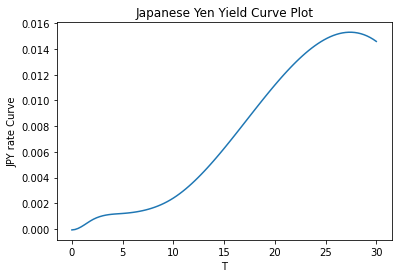

In [10]:
jpy_yield_curve = [0.000, 0.0002, 0.0007, 0.0012, 0.0024, 0.0112, 0.0146]
jpy_maturities = [0.5, 1, 2, 5, 10, 20, 30]

'''
Generate yield curves for Japanese Rates
'''

def get_japanese_rates(jpy_yield_curve, jpy_maturities, time):
    
    jpy_curve = scint.CubicSpline(jpy_maturities, jpy_yield_curve)
#     plt.xlabel(jpy_maturities)
#     plt.ylabel(jpy_yield_curve)
    plt.xlabel("T")
    plt.ylabel("JPY rate Curve")
    plt.title("Japanese Yen Yield Curve Plot")
    X = np.linspace(0, 30, num=100, endpoint=True)
    Y = jpy_curve(X)
    plt.plot(X, Y)
    return jpy_curve(time)

get_japanese_rates(jpy_yield_curve, jpy_maturities, 1)
# plt.xlabel(jpy_maturities)
# plt.ylabel(jpy_yield_curve)
# plt.plot(maturities, libor_curve)

In [11]:
'''
Get 3-m Libor data for historical correlations
'''
def get_LIBOR_3m():
    
    libor = pd.read_csv('LIBOR3m.csv')
    libor = np.array(libor['Close'])
    for i in range(len(libor)):
        libor[i] = libor[i].replace('%', '')
        libor[i] = float(libor[i])
    libor = libor.astype(float)
    libor_log_returns = []
    previous = libor[0]
    
    for i in range(1, len(libor)):
        libor_log_returns.append(np.log(libor[i]/previous))
        previous = libor[i]
        
    return libor_log_returns

In [12]:
'''
Simulating the paths for Hull-White model

'''

def calc_caplet_pricer(theta, L0, strike, alpha, sigma, paths, steps, z1, z2, rho, extra_steps):
    
    price_paths = np.zeros( (paths, (steps)), np.float64)
    w = rho * z1 + np.sqrt(1 - rho*rho) * z2
    
    for i in range(paths):
        price_paths[i,0] = L0
    
    dt = 0.001
    
    for k in range(steps - 1):
        
        price_paths[:,k+1] = price_paths[:,k] + (theta - alpha * price_paths[:,k])*dt + w[:,k]*sigma*np.sqrt(dt)

    extra_paths = np.zeros((paths, (extra_steps)), np.float64)
    
    for i in range(paths):
        extra_paths[i,0] = price_paths[i, steps - 1]
        
    for k in range(extra_steps - 1):
        extra_paths[:,k+1] = extra_paths[:,k] + (theta - alpha * extra_paths[:,k])*dt + np.random.standard_normal(size = paths)*sigma*np.sqrt(dt)
    
    disc_extra_paths = extra_paths[:, extra_steps - 1] * np.exp(-0.049*0.25)
    disc_price_paths = (strike - disc_extra_paths/L0)
    #price_paths = np.average(price_paths)
    print(len(disc_price_paths))
    return disc_price_paths

#paths_cap = calc_caplet_pricer(0.09, 0.05, 1.5, 0.06, 0.04, paths, steps, z1, z2, 0.6, 100)
# T = np.linspace( 0., 2, steps)
# plt.xlabel("T")
# plt.ylabel("LIBOR-3m")
# plt.title("Simulating 50 paths for LIBOR w/ time")
# for i in range(50):
#     plt.plot(T, paths_cap[i])
# plt.show()

In [13]:
'''
Input Values for the model, 

S0, L0, T, k, k'. Sample inputs
'''
libor_curve = [0.0471, 0.049, 0.052, 0.0525, 0.0539, 0.0540, 0.0551, 0.0562, 0.0578, 0.0631]
yield_curve = [0.0377, 0.0434, 0.0467, 0.0468, 0.0470, 0.0406, 0.0375, 0.0361, 0.0357, 0.0365]
maturities = [1/12, 1/4, 1/2, 1, 2, 3, 5, 7, 10, 30]
jpy_yield_curve = [0.0, 0.0, 0.0, 0.0012, 0.0024, 0.0112, 0.0146]
jpy_maturities = [0.5, 1, 2, 5, 10, 20, 30]


S0 = 2800   # Initial N225
L0 = 0.052  # Initial LIBOR value which is the current 1-year LIBOR rate, varies with T. 
T = 1       # 1 year
k = 1.1     # Strike Ratio of N225
k1 = 1.2    # LIBOR ratio
alpha = 0.06

## The main pricing function. Please run this to test the routine. 

def pricing_function():
    
    r_local = get_japanese_rates(jpy_yield_curve, jpy_maturities, T)
    print("Japanese rate for the given maturity is: ", r_local)
    
    n225_fx_corr = get_equity_fx_correlation()
    print("Correlation between N225 and USD/JPY comes out to be, ", n225_fx_corr)
    
    vol_idx = get_vol_idx(k, T, S0)
    print("N225 IV is: ", vol_idx)

    vol_fx = get_vol_fx(k, T, S0)
    print("FX IV is: ", vol_fx)
    
    vol_libor = get_vol_libor(k, T, S0)
    print("LIBOR IV is: ", vol_libor)
    
    paths = 1000    #Simulation paramters
    steps = 1000    #Simulation paramters
    
    np.random.seed(17)
    z1 = np.random.standard_normal(size = (paths, steps)) # standard normal 1
    z2 = np.random.standard_normal(size = (paths, steps)) # standard normal 2
    
    quanto_prices = calc_quanto_pricer(r_local, S0, k, n225_fx_corr, vol_idx, vol_fx, paths, steps, z1)
    print("Quanto paths for all the final payoffs are: ", quanto_prices)
    
    libor_N225_corr = get_LIBOR_N225()
    print("LIBOR-3m N225 correlation is: ", libor_N225_corr)
    
    theta = get_theta(alpha, vol_libor, T)
    print("Theta in Hull-White calibration is: ", theta)
    
    vol_hw = convert_volatility(vol_libor, alpha, 0.25, T)   #delta is 3 months
    print("Hull-White volatility converted from Black-Scholes: ", vol_hw)
    
    extra_steps = int(.25/0.001)         # Code uses dt as 0.001 and delta for the problem is 0.25.  
    caplet_prices = calc_caplet_pricer(theta, L0, k1, alpha, vol_hw, paths, steps, z1, z2, libor_N225_corr, extra_steps)
    print("Caplet paths after T + delta steps is: ", caplet_prices)
    
    prices = []
    for i in range(paths):
        prices.append(max(caplet_prices[i]*quanto_prices[i], 0))

    final_price = np.average(prices)
    print("Final Price of the security is: ", final_price)
    return final_price

Japanese rate for the given maturity is:  0.0
Correlation between N225 and USD/JPY comes out to be,  0.770112674708485
Fetching SPX market data.....
    Strike      Bid     Ask  Midpoint  Moneyness            volMarketData  \
0    800.0     1.45     2.0     1.725  -1.252763     [0.5127314706607033]   
1   1800.0    11.60    12.8    12.200  -0.441833    [0.26978854282421405]   
2   2500.0    36.10    38.2    37.150  -0.113329     [0.1347940770801268]   
3   2600.0    42.50    44.7    43.600  -0.074108    [0.11322699386898172]   
4   2700.0    50.00    52.6    51.300  -0.036368    [0.08934552878780888]   
5   2800.0    58.80    61.7    60.250   0.000000     [0.0601400976669797]   
6   2900.0    69.20    72.4    70.800   0.035091  [0.0031375080233304597]   
7   3000.0    81.60    85.0    83.300   0.068993  [0.0020056166726756253]   
8   3100.0    95.80    99.6    97.700   0.101783   [0.012275785170616227]   
9   3150.0   103.60   107.7   105.650   0.117783    [0.00860359996539628]   
10  

[0.0872, 1.3634, 0.2365, 0.0302, 0.002]
0.0
Fetching SPX market data.....
    Strike      Bid     Ask  Midpoint  Moneyness            volMarketData  \
0    800.0     1.45     2.0     1.725  -1.252763     [0.5127314706607033]   
1   1800.0    11.60    12.8    12.200  -0.441833     [0.2697885428242133]   
2   2500.0    36.10    38.2    37.150  -0.113329     [0.1347940770801268]   
3   2600.0    42.50    44.7    43.600  -0.074108    [0.11322699386898172]   
4   2700.0    50.00    52.6    51.300  -0.036368    [0.08934552878780888]   
5   2800.0    58.80    61.7    60.250   0.000000     [0.0601400976669797]   
6   2900.0    69.20    72.4    70.800   0.035091   [0.001452730827990023]   
7   3000.0    81.60    85.0    83.300   0.068993  [0.0025427310035055495]   
8   3100.0    95.80    99.6    97.700   0.101783   [0.004349082042617414]   
9   3150.0   103.60   107.7   105.650   0.117783   [0.008498780440516551]   
10  3200.0   112.30   116.2   114.250   0.133531    [0.00306183061845422]   
11

[0.0872, 1.3634, 0.2365, 0.0302, 0.002]
0.0
Fetching SPX market data.....
    Strike      Bid     Ask  Midpoint  Moneyness            volMarketData  \
0    800.0     1.45     2.0     1.725  -1.252763     [0.5127314706607033]   
1   1800.0    11.60    12.8    12.200  -0.441833    [0.26978854282421405]   
2   2500.0    36.10    38.2    37.150  -0.113329     [0.1347940770801268]   
3   2600.0    42.60    44.8    43.700  -0.074108    [0.11334603380292785]   
4   2700.0    50.50    52.6    51.550  -0.036368     [0.0896000407876727]   
5   2800.0    58.90    61.8    60.350   0.000000   [0.060230195217456206]   
6   2900.0    69.50    72.5    71.000   0.035091   [0.002706012642997857]   
7   3000.0    81.90    85.1    83.500   0.068993  [0.0015231517607583456]   
8   3100.0    96.30    99.7    98.000   0.101783   [0.008532072897650456]   
9   3150.0   104.40   107.8   106.100   0.117783   [0.012148617221263147]   
10  3200.0   112.30   116.4   114.350   0.133531   [0.014272608948931897]   
11

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 258 and the array at index 1 has size 501

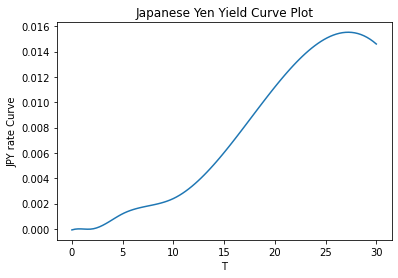

In [14]:
### To run the code

pricing_function()